In [2]:
import pymysql
import dataset
import MySQLdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\matthewkent.regalado\Anaconda3\envs\project-env\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\matthewkent.regalado\Anaconda3\envs\project-env\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\matthewkent.regalado\Anaconda3\envs\project-env\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Import scraped App Store Reviews
---

In [3]:
as_df = pd.read_csv('data/app_store_reviews.csv')
as_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               1669 non-null   object
 1   review             1669 non-null   object
 2   title              1669 non-null   object
 3   userName           1669 non-null   object
 4   isEdited           1669 non-null   bool  
 5   rating             1669 non-null   int64 
 6   developerResponse  1 non-null      object
dtypes: bool(1), int64(1), object(5)
memory usage: 80.0+ KB


## Preprocess data
---

### Remove punctuation from all reviews

In [234]:
as_df['review']

0       This app gets so many negative reviews but it’...
1       I've been using gcash for 2 years now, and yes...
2       Okay GCash dati 3-4 years ago. Ngayon puro err...
3       Those others who doesn’t like gcash don’t expe...
4       This is the worst experience I had with gcash!...
                              ...                        
1664    Everytime I enroll bpi for the cash-in, it pro...
1665    Anong klaseng app b nmn to wla nanaman transac...
1666    My app was recently updated and the transactio...
1667            Ita not working properly to Iphone xs max
1668    Please put STUDENT ID to be fully verified . S...
Name: review, Length: 1669, dtype: object

In [238]:
import string

# init empty lists
clean_lst = []
rating_lst = []

for review, rating in zip(as_df['review'], as_df['rating']):
    # convert each review to a string to avoid AttributeErrors while using the translate method
    str_review = str(review)
    clean_review = str_review.translate(str.maketrans('', '', string.punctuation))
    clean_lst.append(clean_review)
    rating_lst.append(rating)

### Remove emojis/emoticons, flags (iOS), pictographs, and transportation and map symbols from all reviews

In [5]:
import re

def cleaner(text):
    regrex_pattern = re.compile(
        pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    
    return regrex_pattern.sub(r'',text)

# init empty list
final_lst = []

for review in clean_lst:
    final_review = cleaner(review)
    # use the strip method to remove leading and trailing characters before appending the cleaned review into the list
    final_lst.append(final_review.strip())

In [215]:
import itertools
import collections

# set all strings to lowercase and split every line to strings
review_lst = [line.lower().split() for line in final_lst]

### Remove stopwords using the nltk and advertools libraries

In [110]:
# https://www.nltk.org/
# import the Natural Language Toolkit (nltk) library to further process the parsed word data
import nltk
import advertools as adv
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(adv.stopwords['tagalog'])

# Remove stop words from each line
clean_review_lst = [[word for word in words if not word in stop_words] for words in review_lst]

new_words = [' '.join(word) for word in clean_review_lst]
as_df['clean_review'] = new_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matthewkent.regalado\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


### Verify results

In [111]:
# compare original output from 'cleaned' output 
print(f'\nOriginal (length: {len(as_df.iloc[6, 1].split())}):\n{as_df.iloc[6, 1].split()}')
print(f'\nPreprocessed (length: {len(clean_review_lst[6])}):\n{clean_review_lst[6]}\n')


Original (length: 170):
['My', 'old', 'account', 'number', 'was', 'blocked', 'and', 'can’t', 'receive', 'any', 'messages', 'anymore.', 'So,', 'I', 'immediately', 'called', 'the', 'customer', 'service', 'on', 'June', '30,', '2020,', 'about', 'the', 'issue', 'and', 'asked', 'me', 'to', 'create', 'a', 'new', 'Gcash', 'account', 'because', 'they', 'will', 'send', 'there', 'my', 'balance', 'on', 'my', 'previous', 'account.', 'They', 'asked', 'for', 'all', 'the', 'details', 'they', 'needed', 'through', 'email', 'and', 'sent', 'it', 'to', 'them', 'immediately.', 'After', '2', 'days', '(July', '2)', 'I', 'received', 'an', 'email', 'from', 'them', 'that', 'the', 'amount', 'was', 'already', 'sent', 'on', 'my', 'new', 'account', 'they', 'sent', 'a', 'reference', 'number', 'with', 'date,', 'I', 'already', 'told', 'them', 'that', 'I', 'didn’t', 'receive', 'either', 'the', 'money', 'or', 'the', 'reference', 'number.', 'I', 'immediately', 'called', 'the', 'customer', 'service', 'and', 'keep', 'calli

In [228]:
# use the chain function from Python's built-in itertools library 
# to convert the series of iterables (list of lists) to a single iterable (list)
words = list(itertools.chain(*clean_review_lst))

# use the Counter method from Python's built-in collections library to 
# store each word as a dictionary key, and their occurrences as their corresponding value
word_freqs = collections.Counter(words)

word_lst = []
count_lst = []

# use the most_common method to return the most common words based on their counts
# from the most common to the least
most_common = word_freqs.most_common(10)
for word, count in most_common:
    word_lst.append(word)
    count_lst.append(count)
    
freqs_df = pd.DataFrame()
freqs_df['word'] = word_lst
freqs_df['count'] = count_lst

## 2. Build a classifier using an SVM to identify whether a review is a 1-star or 5-star review
---

In [112]:
as_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               1669 non-null   object
 1   review             1669 non-null   object
 2   title              1669 non-null   object
 3   userName           1669 non-null   object
 4   isEdited           1669 non-null   bool  
 5   rating             1669 non-null   int64 
 6   developerResponse  1 non-null      object
 7   clean_review       1669 non-null   object
dtypes: bool(1), int64(1), object(6)
memory usage: 93.0+ KB


In [113]:
# query and display 5 randomly selected samples from the reviews DF
reviews_df = as_df.drop(['title', 'userName', 'isEdited', 'developerResponse', 'review'], axis=1)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1669 non-null   object
 1   rating        1669 non-null   int64 
 2   clean_review  1669 non-null   object
dtypes: int64(1), object(2)
memory usage: 39.2+ KB


In [114]:
reviews_df

,date,rating,clean_review
0,2020-05-16 07:33:32,5,app gets many negative reviews it’s actually b...
1,2020-06-07 04:57:17,5,ive using gcash 2 years yes perfect helped lot...
2,2020-04-26 04:57:47,1,okay gcash dati 34 years ago puro errors fully...
3,2021-01-12 09:46:26,5,others doesn’t like gcash don’t expect much gc...
4,2020-02-10 15:45:41,1,worst experience gcash tried cash mypaypal acc...
...,...,...,...
1664,2020-01-05 13:52:04,1,everytime enroll bpi cashin prompts username p...
1665,2021-06-03 03:10:39,1,anong klaseng app b nmn wla nanaman transactio...
1666,2021-06-03 01:37:56,1,app recently updated transaction history tab a...
1667,2021-03-16 04:41:58,1,ita working properly iphone xs max


In [115]:
reviews_df['datetime'] = pd.to_datetime(reviews_df['date'])
reviews_df = reviews_df.drop(['date'], axis=1)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   rating        1669 non-null   int64         
 1   clean_review  1669 non-null   object        
 2   datetime      1669 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 39.2+ KB


In [116]:
reviews_df

,rating,clean_review,datetime
0,5,app gets many negative reviews it’s actually b...,2020-05-16 07:33:32
1,5,ive using gcash 2 years yes perfect helped lot...,2020-06-07 04:57:17
2,1,okay gcash dati 34 years ago puro errors fully...,2020-04-26 04:57:47
3,5,others doesn’t like gcash don’t expect much gc...,2021-01-12 09:46:26
4,1,worst experience gcash tried cash mypaypal acc...,2020-02-10 15:45:41
...,...,...,...
1664,1,everytime enroll bpi cashin prompts username p...,2020-01-05 13:52:04
1665,1,anong klaseng app b nmn wla nanaman transactio...,2021-06-03 03:10:39
1666,1,app recently updated transaction history tab a...,2021-06-03 01:37:56
1667,1,ita working properly iphone xs max,2021-03-16 04:41:58


## Data visualization
---

Text(0.5, 1.0, "\nRecommendations vs 'Constructive' Criticism\n")

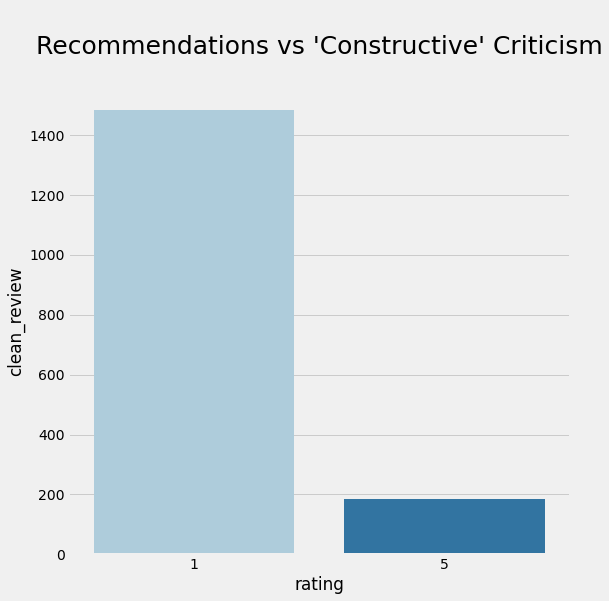

In [117]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,8))

df_2 = reviews_df.groupby('rating').count()
df_2.reset_index(inplace=True)
ax = sns.barplot(x='rating', y='clean_review', data=df_2, palette='Paired');
ax.set_title('\nRecommendations vs \'Constructive\' Criticism\n', fontsize=25)

# values = reviews_df['rating'].value_counts()

# for i, p in enumerate(ax.patches):
#     height = p.get_height()
#     ax.text(p.get_x() + p.get_width() / 2, height, values[i], ha="center")

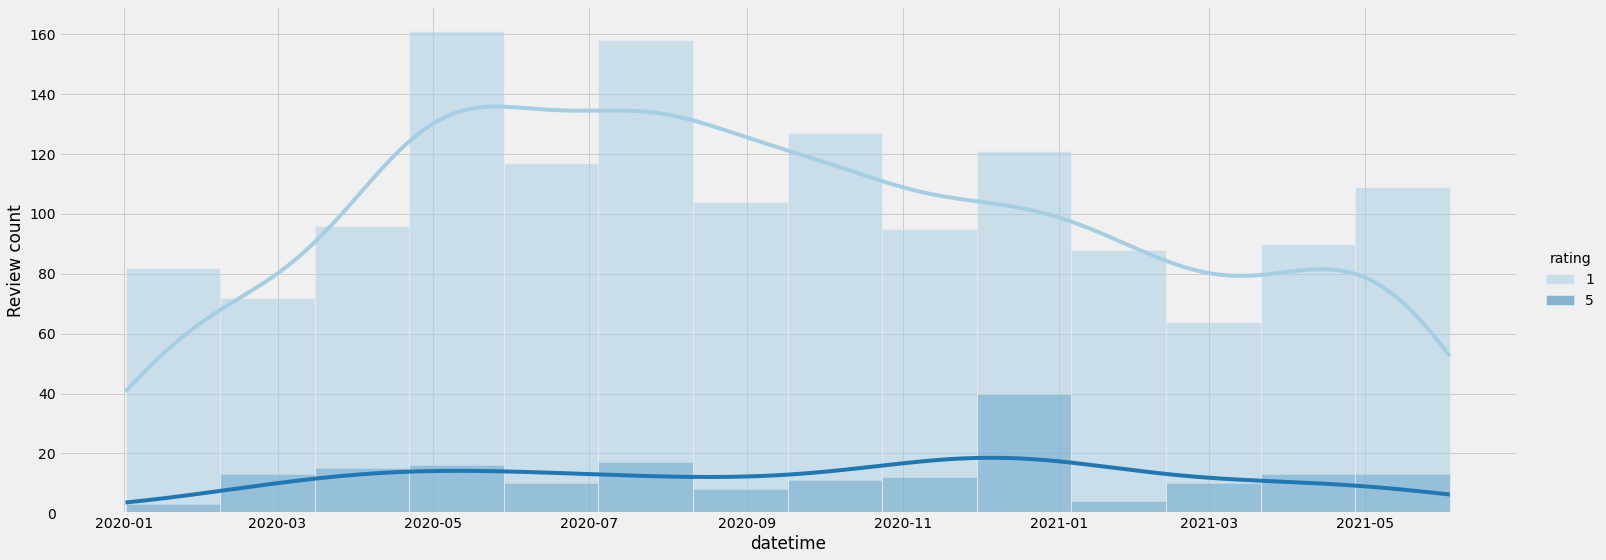

In [118]:
plt.style.use('fivethirtyeight')

s = sns.displot(data=reviews_df, x='datetime', hue='rating', height=8, aspect=2.7, palette='Paired', kde=True)
s.set(ylabel='Review count')

## Model training
---

In [166]:
# init tf-idf vectorizer
vectorizer = TfidfVectorizer()

# vectorize the comments data
vectorized_X = vectorizer.fit_transform(reviews_df['clean_review'])

print('\nrows, features/words:')
vectorized_X.shape


rows, features/words:


(1669, 4775)

In [174]:
# split the vectorized data
train_X, test_X, train_Y, test_Y = train_test_split(vectorized_X, reviews_df['rating'], train_size=0.2) 

print(train_X.shape, test_X.shape)

(333, 4775) (1336, 4775)


In [211]:
# used LinearSVC instead since SVC takes a while to process
from sklearn.svm import LinearSVC

# init Scalable Linear SVM classifier
classifier = SVC(kernel='linear')
# classifier = LinearSVC()

# train Linear SVM classifier
classifier.fit(train_X.toarray(), train_Y)

SVC(kernel='linear')

In [212]:
# use cross validation to see how well a Linear SVM classifier would work on our data
scores = cross_val_score(classifier, test_X, test_Y, cv=10)
acc = scores.mean()
print("\nAccuracy: %0.2f percent (+/- %0.2f)" % (acc*100, scores.std()))

scores


Accuracy: 91.17 percent (+/- 0.01)


array([0.89552239, 0.91044776, 0.91791045, 0.91791045, 0.90298507,
       0.92537313, 0.91729323, 0.90977444, 0.92481203, 0.89473684])

## Visualize the SVM's Support Vectors (WIP)
---

## Identify the top words from the clean_review column
---

In [25]:
import itertools
import collections

# extract and convert all of the pros column's rows to a list of lists
linesInPros = list(reviews_df['clean_review'].values)

# set all strings to lowercase and split every line to strings
prosListOfLists = [line.lower().split() for line in linesInPros]

# use the chain function from Python's built-in itertools library 
# to convert the series of iterables (list of lists) to a single iterable (list)
wordsInPros = list(itertools.chain(*prosListOfLists))

# use the Counter method from Python's built-in collections library to 
# store each word as a dictionary key, and their occurrences as their corresponding value
prosWordFreqs = collections.Counter(wordsInPros)

# use the most_common method to return the most common words based on their counts
# from the most common to the least
prosWordFreqs.most_common(10)

[('i', 2075),
 ('to', 1774),
 ('the', 1616),
 ('my', 1169),
 ('and', 1156),
 ('it', 959),
 ('a', 829),
 ('app', 811),
 ('gcash', 775),
 ('is', 769)]

<AxesSubplot:title={'center':'\nTop 10 Most Common Words in clean_review Column\n'}, ylabel='words'>

<Figure size 1440x1440 with 0 Axes>

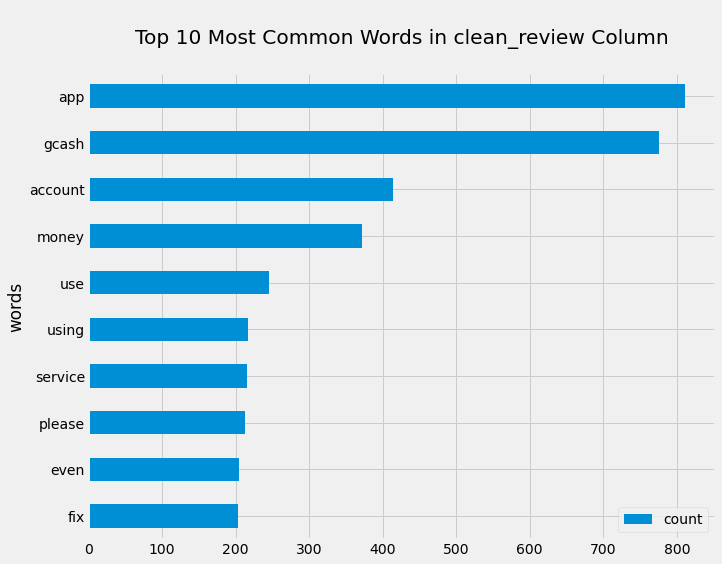

In [220]:
plt.figure(figsize=(20,20))

# create a DF for analysis and plotting that includes only the top 10 most common words in the pros and cons columns
# most_common_words_cons = pd.DataFrame(consWordFreqs.most_common(10), columns=['words', 'count'])
most_common_words = pd.DataFrame(word_freqs.most_common(10), columns=['words', 'count'])

# fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot horizontal bar graph
most_common_words.sort_values(by='count').plot.barh(x='words', y='count', title='\nTop 10 Most Common Words in clean_review Column\n', figsize=(10, 8))
# most_common_words_cons.sort_values(by='count').plot.barh(x='words', y='count', ax=ax[1], title='\nTop 10 Most Common Words in Cons Column\n')

# plt.show()

In [29]:
cleanPros = list(itertools.chain(*clean_pros_words))
# cleanCons = list(itertools.chain(*cons_puncs_removed))

# # remove empty strings
# def removeEmptyStrings(lst):
#     while ("" in lst):
#         lst.remove("")
    
#     return lst

# removeEmptyStrings(cleanPros)
# removeEmptyStrings(cleanCons)

newProsWordFreqs = collections.Counter(cleanPros)
# newConsWordFreqs = collections.Counter(cleanCons)

# create a DF for analysis and plotting that includes only the top 10 most common words
finalPros = pd.DataFrame(newProsWordFreqs.most_common(10), columns=['words', 'count'])
# finalCons = pd.DataFrame(newConsWordFreqs.most_common(10), columns=['words', 'count'])

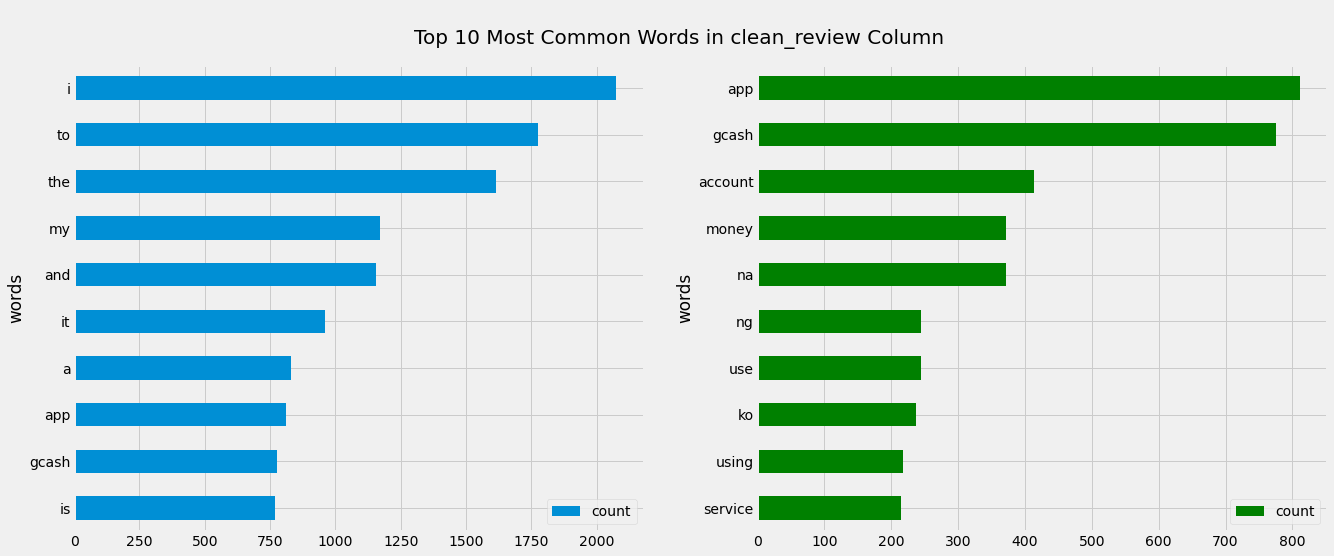

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot horizontal bar graph
most_common_words_pros.sort_values(by='count').plot.barh(x='words', y='count', ax=ax[0])
finalPros.sort_values(by='count').plot.barh(x='words', y='count', ax=ax[1], color='green')
fig.suptitle('\nTop 10 Most Common Words in clean_review Column\n', fontsize=20)

plt.show()